# COVID-19 Ultimate: Chronology + Patients analysis
### Quick introduction:

Coronavirus desease **COVID-19** is caused by **SARS-COV-2** corona virus.

Started in Wuhan,Hubei, China in late 2019, the epidemy has been progressing over the time becoming pandemic in February 2020.

On 30 January the World Health Organization declared the outbreak to be a Public Health Emergency of International Concern.

COVID-19 caused global reductions in flight connection and border lockdowns in many countries.


### Acknowledgements

I would like to thank **The Johns Hopkins University Center for Systems Science and Engineering** for providing this data.
**The source:**
> https://github.com/CSSEGISandData/COVID-19

This kernel is mainly inspired by another **brilliant work:**

https://www.kaggle.com/imdevskp/covid-19-analysis-viz-prediction-comparisons/notebook

So please take a look at that one and do rate it up, **please!**

#### Libraries import

In [1]:
# table data libs
import numpy as np
import pandas as pd
from pandas_datareader import wb

# visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
from plotly.subplots import make_subplots

# predefine color pallette alias
cnf = 'grey' # confirmed
dth = 'red' # death
rec = 'lightgreen' # recovered
act = 'orange' # active

# converter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()   

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# html embedding
from IPython.display import Javascript
from IPython.core.display import display
from IPython.core.display import HTML

# to improve matplotlib graphs
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

#### Dataset import and preprocessing

In [2]:
# Daily general statistics per country - cleaned
daily_stat = pd.read_csv('../input/corona-virus-report/covid_19_clean_complete.csv', 
                         parse_dates=['Date'])

# Active Case = confirmed - deaths - recovered
daily_stat['Active'] = daily_stat['Confirmed'] - daily_stat['Deaths'] - daily_stat['Recovered']

# Not all provinces are present - fillna
daily_stat[['Province/State']] = daily_stat[['Province/State']].fillna('')

# predefine latest available report for current situation statistics 
last_report = daily_stat[daily_stat['Date'] == max(daily_stat['Date'])].reset_index()

# last_report grouped by countries and Chinese provinces
countries_last_report = last_report.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
china_last_report = last_report[last_report['Country/Region']!='China'].groupby('Province/State')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()

# -------------------------------
# READING POPULATION DENSITY DATA

# Reading and cleaning the data - this code is taken from worldbankdataset 
wb_countries = wb.get_countries()
country_list = wb_countries[wb_countries['region']!='Aggregates']['name'].reset_index(drop=True)

indicator_ids = ['EN.POP.DNST', 'SP.POP.TOTL', 'SM.POP.NETM']

migration = wb.WorldBankReader(symbols=['SM.POP.NETM'], start=1950, end=2018, countries='all').read()
pop_density = wb.WorldBankReader(symbols=['EN.POP.DNST'], start=1950, end=2018, countries='all').read()
population = wb.WorldBankReader(symbols=['SP.POP.TOTL'], start=1950, end=2018, countries='all').read()

pop_density_countries = pop_density.reset_index()#.query('country in @country_list').reset_index(drop=True)
population_countries = population.reset_index()#.query('country in @country_list').reset_index(drop=True)
migration_countries = migration.reset_index()#.query('country in @country_list').reset_index(drop=True)

pop_density_merged = pd.merge(population_countries, pop_density_countries, on=['country', 'year'], how='outer')
migration_final = (pd.merge(pop_density_merged, migration_countries, on=['country', 'year'], how='outer')
                   .rename(columns={'SP.POP.TOTL': 'population',
                                    'EN.POP.DNST': 'pop_density',
                                    'SM.POP.NETM': 'net_migration'})
                   .assign(migration_perc=lambda df: df['net_migration'].div(df['population'])))

migration_final = pd.merge(migration_final, wb_countries, how='left', left_on='country', right_on='name')
migration_final.drop('name', axis=1).to_csv('migration_population.csv', index=False)

migration_final['year'] = migration_final['year'].astype(int)
pop_info = migration_final[migration_final['year']==2018][['country','population','pop_density']]

# substitute for missing values
cols = ['Curacao','Eritrea', 'Monaco','South Sudan','Sudan']
pops = [370, 35, 26337,18,25]
for c, p in zip(cols, pops):
    pop_info.loc[pop_info['country']== c, 'pop_density'] = p

# replace country names 
name = {
    'Congo, Dem. Rep.': 'Congo (Kinshasa)',
    'Egypt, Arab Rep.': 'Egypt',
    'Hong Kong SAR, China': 'Hong Kong',
    'Iran, Islamic Rep.': 'Iran (Islamic Republic of)',
    'Macao SAR, China': 'Macau',
    'Hong Kong SAR': 'Hong Kong',
    'Russian Federation': 'Russia',
    'Slovak Republic': 'Slovakia',
    'Korea, Rep.': 'Republic of Korea',
    'United Kingdom': 'UK',
    'United States': 'US' }
pop_info.loc[:, 'country'] = pop_info.loc[: 'country'].replace(name)


# 1. Current situation

### Short summary

General situation as-is according to the latest report:

In [3]:
temp = daily_stat.groupby('Date')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
temp = temp[temp['Date']==max(temp['Date'])].reset_index(drop=True)

# Pandas styling tool - we can apply any custom function to every series
def coloring(s):
    if s.name =='Confirmed':
        return ['background-color: ' + cnf for v in s]
    elif s.name =='Deaths':
        return ['background-color: ' + dth for v in s]
    elif s.name =='Recovered':
        return ['background-color: ' + rec for v in s]
    elif s.name =='Active':
        return ['background-color: ' + act for v in s]
    else:
        return ['' for v in s]
temp.style.apply(coloring,axis=0)

In [4]:
fig = px.sunburst(last_report.sort_values(by='Confirmed', ascending=False).reset_index(drop=True), path=["Country/Region", "Province/State"], values="Confirmed", title='Confirmed Cases', color_discrete_sequence = px.colors.qualitative.Prism)
fig.data[0].textinfo = 'label+text+value'
fig.show()

### TOP 20 Countries by confirmed cases

In [5]:
temp_f = countries_last_report.sort_values(by='Confirmed', ascending=False)
temp_f = temp_f.reset_index(drop=True)
temp_f.iloc[:20].style.background_gradient(cmap='Reds')

In [6]:
temp = temp_f.iloc[:20].sort_values(by='Confirmed', ascending=True)

fig = go.Figure()

fig.add_trace(go.Bar(
    y=temp['Country/Region'],
    x=temp['Deaths'],
    name='Deaths',
    orientation='h',
    marker=dict(
        color=dth)
    )
)
fig.add_trace(go.Bar(
    y=temp['Country/Region'],
    x=temp['Recovered'],
    name='Recovered',
    orientation='h',
    marker=dict(
        color=rec)
    )
)

fig.add_trace(go.Bar(
    y=temp['Country/Region'],
    x=temp['Active'],
    name='Active',
    orientation='h',
    marker=dict(
        color=act)
    )
)

fig.update_layout(barmode='stack')
fig.show()

### Confirmed cases map

In [7]:
formated_gdf = daily_stat.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths', 'Recovered'].max()
formated_gdf = formated_gdf.reset_index()
formated_gdf['Date'] = pd.to_datetime(formated_gdf['Date'])
formated_gdf['Date'] = formated_gdf['Date'].dt.strftime('%m/%d/%Y')
formated_gdf['size'] = formated_gdf['Confirmed'].pow(0.4)

fig = px.scatter_geo(formated_gdf, locations="Country/Region", locationmode='country names', 
                     color="Confirmed", size='size', hover_name="Country/Region", 
                     range_color= [0, max(formated_gdf['Confirmed'])+2],
                     title='Spread over time',)
fig.update(layout_coloraxis_showscale=False)
fig.update_geos(
    resolution=50,
    showland=True, landcolor="DarkGrey",
    showocean=True, oceancolor="DimGrey",
    showlakes=True, lakecolor="DimGrey",
    showcountries=True, countrycolor="lightGrey"
)
fig.update_layout(height=500, margin={"r":0,"t":0,"l":0,"b":0})
#fig.update_geos(lataxis_showgrid=True, lonaxis_showgrid=True)
fig.show()

### Death cases map

In [8]:
formated_gdf = daily_stat.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths', 'Recovered'].max()
formated_gdf = formated_gdf.reset_index()
formated_gdf['Date'] = pd.to_datetime(formated_gdf['Date'])
formated_gdf['Date'] = formated_gdf['Date'].dt.strftime('%m/%d/%Y')
formated_gdf['size'] = formated_gdf['Deaths'].pow(0.3)

fig = px.scatter_geo(formated_gdf, locations="Country/Region", locationmode='country names', 
                     size='size', hover_name="Country/Region", color_discrete_sequence=[dth],
                     title='Spread over time')

            
fig.update(layout_coloraxis_showscale=False)
fig.update_geos(
    resolution=50,
    showland=True, landcolor="DarkGrey",
    showocean=True, oceancolor="DimGrey",
    showlakes=True, lakecolor="DimGrey",
    showcountries=True, countrycolor="lightGrey"
)
fig.update_layout(height=500, margin={"r":0,"t":0,"l":0,"b":0})
#fig.update_geos(lataxis_showgrid=True, lonaxis_showgrid=True)
fig.show()

# Death and recovery rates in different countries

In [9]:
# NOTE: we take into analysis only countries with sufficient statistics (at least 100 confirmed cases)
temp = countries_last_report.copy()
temp['Death Rate'] = round((temp['Deaths']/temp['Confirmed'])*100, 2)
temp = temp[temp['Confirmed']>100]
temp = temp.sort_values('Death Rate', ascending=False)

fig = px.bar(temp.sort_values('Death Rate', ascending=False).head(10).sort_values('Death Rate', ascending=True), 
             x="Death Rate", y="Country/Region", text='Death Rate', orientation='h', 
             height=400, range_x = [0, 20], title='Death rate')
fig.update_traces(marker_color=dth, opacity=0.6, textposition='outside')
fig.show()

temp = countries_last_report.copy()
temp['Recovery Rate'] = round((temp['Recovered']/temp['Confirmed'])*100, 2)
temp = temp[temp['Confirmed']>100]
temp = temp.sort_values('Recovery Rate', ascending=False)

fig = px.bar(temp.sort_values('Recovery Rate', ascending=False).head(10).sort_values('Recovery Rate', ascending=True), 
             x='Recovery Rate', y="Country/Region", text='Recovery Rate', orientation='h', 
              height=400, range_x = [0, 100], title='Recovery Rate')
fig.update_traces(marker_color=rec, opacity=0.8, textposition='outside')
fig.show()

Let's take a closer look at death/recovery relation in TOP 20 countries by confirmed cases (log scale). Size of the ball - number of confirmed cases in the country

In [10]:
fig = px.scatter(countries_last_report.sort_values('Confirmed', ascending=False).iloc[:20, :], 
                 x='Recovered', y='Deaths', color='Country/Region',size='Confirmed',
                 text='Country/Region', log_x=True, log_y=True, title='Deaths vs Recovered')
fig.update_traces(textposition='top center')
fig.show()

### Population and population density of infected countries

Size of the ball - number of confirmed cases in the country

In [11]:
# merge dataframes
temp = pd.merge(countries_last_report, pop_info, how='left', right_on='country', left_on='Country/Region')
# plot
fig = px.scatter(temp.sort_values('Confirmed', ascending=False).iloc[:30, :], 
                 x='pop_density', y='population', color='Country/Region', size='Confirmed',
                 text='Country/Region', log_x=True, log_y=True, title='')
fig.update_traces(textposition='top center')
fig.show()

In [12]:
# calculate Confirmed/Population
temp['Confirmed Per Million People'] = round(temp['Confirmed']/temp['population']*1000000, 2)
temp = temp[temp['population']>1000000].sort_values('Confirmed Per Million People', ascending=False).reset_index(drop=True)

fig = px.bar(temp.head(15).sort_values('Confirmed Per Million People', ascending=True), 
             x='Confirmed Per Million People', y='Country/Region', orientation='h', 
              height=500, text='Confirmed Per Million People', title='Confirmed cases Per Million People',
             range_x = [0, max(temp['Confirmed Per Million People'])+40])
fig.update_traces(textposition='outside', marker_color=cnf, opacity=0.7)
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

# 2. Chronology of virus spread + officials response

* The first case of the novel coronavirus is believed to occur on the 1st December 2019 in Wuhan, Hubei, China.
* In early and mid-January 2020, the virus spread to other Chinese provinces, helped by the Chinese New Year migration, with Wuhan being a transport hub and major rail interchange in China; infected people quickly spread throughout the country.
* On 30 January, the WHO declared the outbreak to be a Public Health Emergency of International Concern.
* On 13 March, the WHO declared Europe to be the new centre of the pandemic, after the rate of new cases in Europe surpassed those recorded in other regions of the world apart from China. 
* By 16 March 2020, the total number of cases reported around the world outside China had exceeded that of Mainland China. As of 16 March 2020, over 179,000 cases have been reported worldwide; more than 7,000 people have died; and over 78,000 have recovered.
* There is thought to be a substantial underreporting of cases, particularly of cases with milder symptoms or no symptoms.

[Sourse - Wiki](https://en.wikipedia.org/wiki/2019%E2%80%9320_coronavirus_pandemic#cite_note-Qun29Jan2020-271)

### Animated map of virus progress

In [13]:
formated_gdf = daily_stat.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths', 'Recovered'].max()
formated_gdf = formated_gdf.reset_index()
formated_gdf['Date'] = pd.to_datetime(formated_gdf['Date'])
formated_gdf['Date'] = formated_gdf['Date'].dt.strftime('%m/%d/%Y')
formated_gdf['size'] = formated_gdf['Confirmed'].pow(0.3)

fig = px.scatter_geo(formated_gdf, locations="Country/Region", locationmode='country names', 
                     color="Confirmed", size='size', hover_name="Country/Region", 
                     range_color= [0, max(formated_gdf['Confirmed'])+2], 
                      animation_frame="Date", 
                     title='Spread over time')
fig.update(layout_coloraxis_showscale=False)
fig.update_geos(
    resolution=110,
    showland=True, landcolor="DarkGrey",
    showocean=True, oceancolor="DimGrey",
    showlakes=True, lakecolor="DimGrey",
    showcountries=True, countrycolor="lightGrey"
)
fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
#fig.update_geos(lataxis_showgrid=True, lonaxis_showgrid=True)
fig.show()

## Spread splitted by case type

In [14]:
# GLOBALLY
temp = daily_stat.groupby('Date')['Recovered', 'Deaths', 'Active'].sum().reset_index()
temp = temp.melt(id_vars="Date", value_vars=['Recovered', 'Deaths', 'Active'],
                 var_name='Case', value_name='Count')
fig = px.area(temp, x="Date", y="Count", color='Case',
             title='Cases over time - Global', color_discrete_sequence = [rec, dth, act], height=400)
fig.show()

# CHINA
temp = daily_stat[daily_stat['Country/Region']=='China'].groupby('Date')['Recovered', 'Deaths', 'Active'].sum().reset_index()
temp = temp.melt(id_vars="Date", value_vars=['Recovered', 'Deaths', 'Active'],
                 var_name='Case', value_name='Count')
temp.head()

fig = px.area(temp, x="Date", y="Count", color='Case',
             title='Cases over time - China', color_discrete_sequence = [rec, dth, act], height=400)
fig.show()

# ROW
temp = daily_stat[daily_stat['Country/Region']!='China'].groupby('Date')['Recovered', 'Deaths', 'Active'].sum().reset_index()
temp = temp.melt(id_vars="Date", value_vars=['Recovered', 'Deaths', 'Active'],
                 var_name='Case', value_name='Count')
temp.head()

fig = px.area(temp, x="Date", y="Count", color='Case',
             title='Cases over time - Rest of the world', color_discrete_sequence = [rec, dth, act],height=400)
fig.show()

* 23 January - quarantine was announced stopping travel in and out of Wuhan. Quarantine was extended to a total of 15 cities in Hubei.
* 26 January - other provinces imposed public places and travel restrictions.

It took nearly 20 days for China to see the effect of such uncompromising and rigorous measures identifying the rest of infected cases and flattening the curve. As for now, they have almost 80% recovery rate.

The infection trend in the rest of the world is still growing exponentially.

## Confirmed cases countrywise timeline

In [15]:
temp = daily_stat.groupby(['Date', 'Country/Region'])['Confirmed'].sum().reset_index().sort_values('Confirmed', ascending=False)
px.line(temp, x="Date", y="Confirmed", color='Country/Region', title='CONFIRMED cases spread - Globally', height=400)

In [16]:
temp = daily_stat[daily_stat['Country/Region']!='China'].groupby(['Date', 'Country/Region'])['Confirmed'].sum().reset_index().sort_values('Confirmed', ascending=False)
px.line(temp, x="Date", y="Confirmed", color='Country/Region', title='CONFIRMED cases timeline - Without China', height=400)

In [17]:
# CHINA
temp = daily_stat[daily_stat['Country/Region']=='China'].groupby('Date').sum().reset_index()
temp['Death rate'] = round(temp['Deaths']/temp['Confirmed'], 3)*100
temp['Recovery rate'] = round(temp['Recovered']/temp['Confirmed'], 3)*100
temp = temp.melt(id_vars='Date', value_vars=['Death rate', 'Recovery rate'], 
                 var_name='Ratio', value_name='Value')
fig = px.line(temp, x="Date", y="Value", color='Ratio', log_y=True, 
              title='Recovery and Mortality Rate over the time - China', color_discrete_sequence=[dth, rec], height=300)
fig.show()

#ROW
temp = daily_stat[daily_stat['Country/Region']!='China'].groupby('Date').sum().reset_index()
temp['Death rate'] = round(temp['Deaths']/temp['Confirmed'], 3)*100
temp['Recovery rate'] = round(temp['Recovered']/temp['Confirmed'], 3)*100
temp = temp.melt(id_vars='Date', value_vars=['Death rate', 'Recovery rate'], 
                 var_name='Ratio', value_name='Value')
fig = px.line(temp, x="Date", y="Value", color='Ratio', log_y=True, 
              title='Recovery and Mortality Rate over the time - Rest of the world', color_discrete_sequence=[dth, rec], height=300)
fig.show()

#Italy
temp = daily_stat[daily_stat['Country/Region']=='Italy'].groupby('Date').sum().reset_index()
temp['Death rate'] = round(temp['Deaths']/temp['Confirmed'], 3)*100
temp['Recovery rate'] = round(temp['Recovered']/temp['Confirmed'], 3)*100
temp = temp.melt(id_vars='Date', value_vars=['Death rate', 'Recovery rate'], 
                 var_name='Ratio', value_name='Value')
fig = px.line(temp, x="Date", y="Value", color='Ratio', log_y=True, 
              title='Recovery and Mortality Rate over the time - Italy', color_discrete_sequence=[dth, rec], height=300)
fig.show()

#Iran
temp = daily_stat[daily_stat['Country/Region']=='Iran'].groupby('Date').sum().reset_index()
temp['Death rate'] = round(temp['Deaths']/temp['Confirmed'], 3)*100
temp['Recovery rate'] = round(temp['Recovered']/temp['Confirmed'], 3)*100
temp = temp.melt(id_vars='Date', value_vars=['Death rate', 'Recovery rate'], 
                 var_name='Ratio', value_name='Value')
fig = px.line(temp, x="Date", y="Value", color='Ratio', log_y=True, 
              title='Recovery and Mortality Rate over the time - Iran', color_discrete_sequence=[dth, rec], height=300)
fig.show()

#Korea
temp = daily_stat[daily_stat['Country/Region']=='South Korea'].groupby('Date').sum().reset_index()
temp['Death rate'] = round(temp['Deaths']/temp['Confirmed'], 3)*100
temp['Recovery rate'] = round(temp['Recovered']/temp['Confirmed'], 3)*100
temp = temp.melt(id_vars='Date', value_vars=['Death rate', 'Recovery rate'], 
                 var_name='Ratio', value_name='Value')
fig = px.line(temp, x="Date", y="Value", color='Ratio', log_y=True, 
              title='Recovery and Mortality Rate over the time - South Korea', color_discrete_sequence=[dth, rec], height=300)
fig.show()

# 3. Some social demographics: South Korea and international data

Let's take a closer look on small, though available patient's data from Korean and international datasets

* Korean dataset contains 56 recovered and 36 deseased patients
* Worldwide dataset contains 159 recovered and 63 dead patients

### Preparing datasets

In [18]:
# Loading and preprocessing Korean dataset
korea_patients = pd.read_csv('../input/coronavirusdataset/PatientInfo.csv', parse_dates=['confirmed_date','released_date','deceased_date'])
korea_patients['age'] = 2020 - korea_patients['birth_year']
korea_recovered = korea_patients[korea_patients['state']=='released']
korea_recovered['cure_time'] = korea_recovered['released_date'] - korea_recovered['confirmed_date']
korea_recovered['cure_time'] = korea_recovered['cure_time'].apply(lambda x: x.days)

korea_deceased = korea_patients[korea_patients['state']=='deceased']
korea_deceased['time_to_death'] = korea_deceased['deceased_date'] - korea_deceased['confirmed_date']
korea_deceased['time_to_death'] = korea_deceased['time_to_death'].apply(lambda x: x.days)

In [19]:
# Loading and preprocessing Global dataset
line = pd.read_csv('../input/novel-corona-virus-2019-dataset/COVID19_line_list_data.csv',parse_dates=['exposure_start','exposure_end'])
line = line[['country','gender','age','exposure_start','exposure_end','death','recovered','symptom']]
line['age'] =line['age'].astype(float)

line_recovered = line[line['recovered']!='0']
line_recovered['cure_time'] = line_recovered['exposure_end'] - line_recovered['exposure_start']
line_recovered['cure_time'] = line_recovered['cure_time'].apply(lambda x: x.days)

line_deceased = line[line['death']!='0']
line_deceased['time_to_death'] = line_deceased['exposure_end'] - line_deceased['exposure_start']
line_deceased['time_to_death'] = line_deceased['time_to_death'].apply(lambda x: x.days)

## Gender shares in confirmed, recovered and death cases

In [20]:
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=korea_patients['sex'].value_counts().index, values=korea_patients['sex'].value_counts().values, name="South Korea confirmed"),
              1, 1)
fig.add_trace(go.Pie(labels=line['gender'].value_counts().index, values=line['gender'].value_counts().values, name="Worldwide confirmed"),
              1, 2)
fig.update_layout(
    title="Confirmed patients in South Korea and Worldwide")
fig.show()


In [21]:
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])    
fig.add_trace(go.Pie(labels=korea_recovered['sex'].value_counts().index, values=korea_recovered['sex'].value_counts().values, name="South Korea recovered"),
              1, 1)
fig.add_trace(go.Pie(labels=line_recovered['gender'].value_counts().index, values=line_recovered['gender'].value_counts().values, name="Worldwide recovered"),
              1, 2)
fig.update_layout(
    title="Recovered patients in South Korea and Worldwide")
fig.show()



In [22]:
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]]) 
fig.add_trace(go.Pie(labels=korea_deceased['sex'].value_counts().index, values=korea_deceased['sex'].value_counts().values, name="South Korea deceased"),
              1, 1)
fig.add_trace(go.Pie(labels=line_deceased['gender'].value_counts().index, values=line_deceased['gender'].value_counts().values, name="Worldwide deceased"),
              1, 2)
fig.update_layout(
    title="Death cases in South Korea and Worldwide")
fig.show()


## Age distribution in confirmed, recovered and death cases

### Recovered

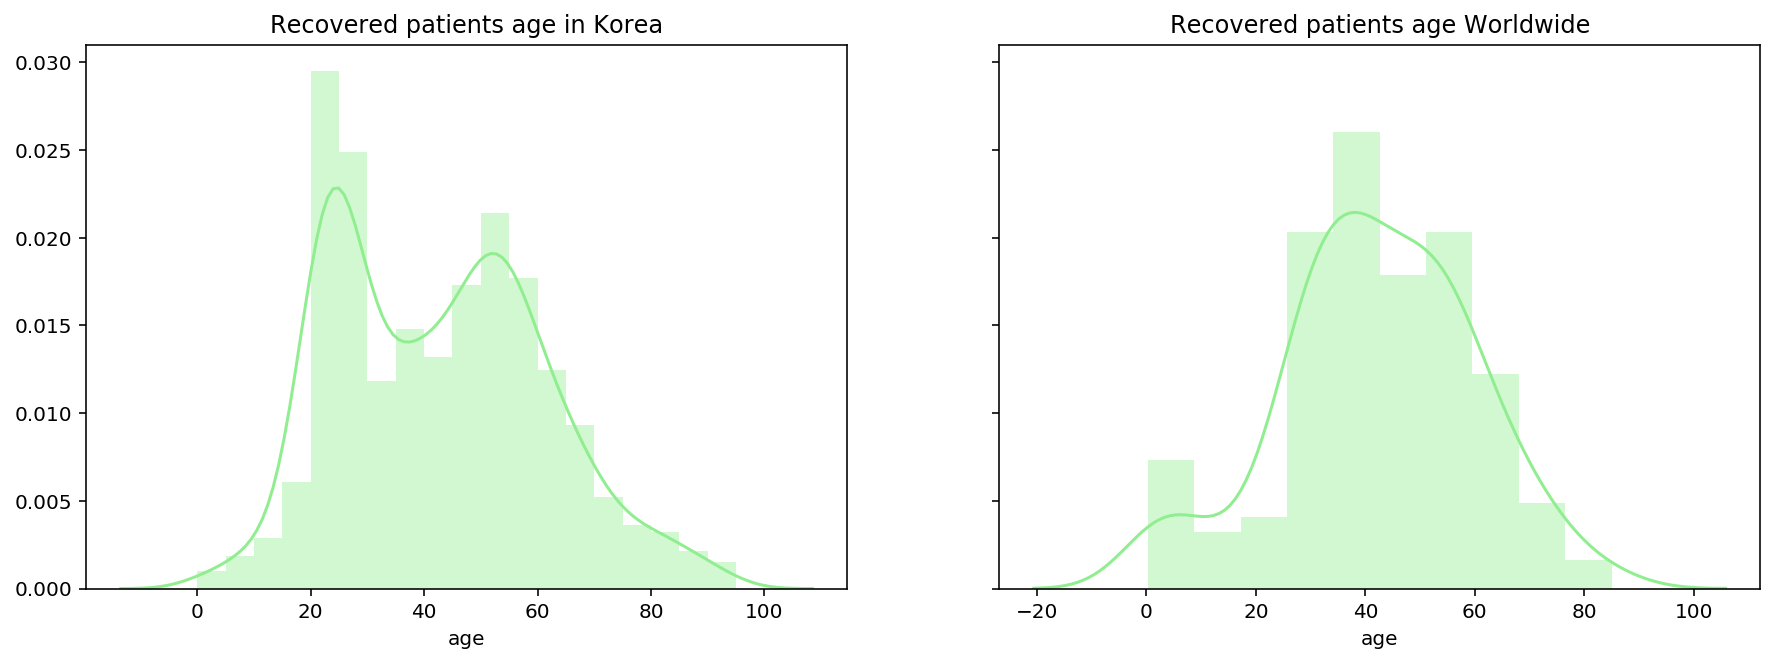

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15, 5))

sns.distplot(korea_recovered[korea_recovered['age'].notnull()]['age'], color=rec, ax=ax1).set_title("Recovered patients age in Korea")
sns.distplot(line_recovered[line_recovered['age'].notnull()]['age'],color=rec, ax=ax2).set_title('Recovered patients age Worldwide')

fig.show()

### Deceased

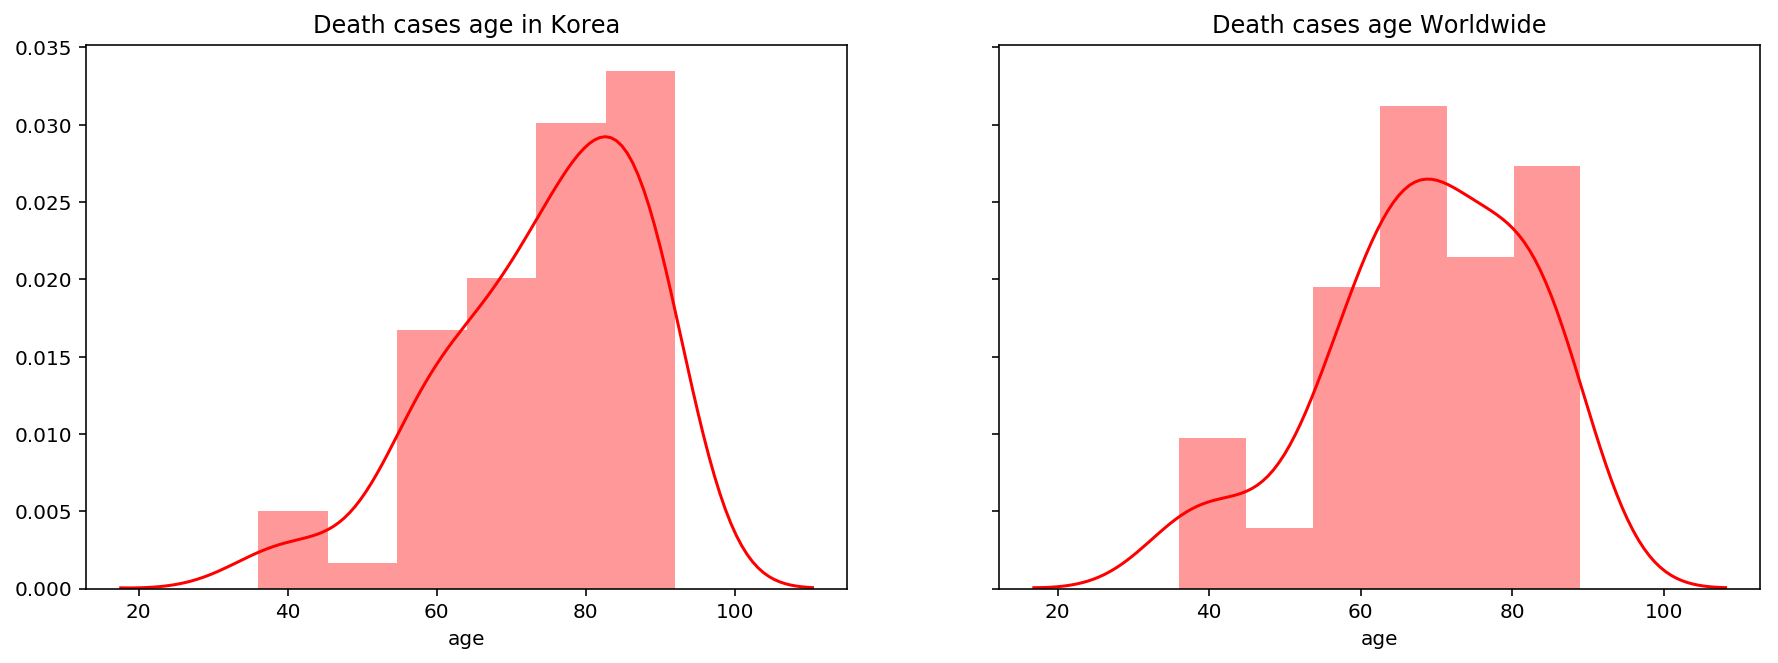

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15, 5))

sns.distplot(korea_deceased[korea_deceased['age'].notnull()]['age'], color=dth, ax=ax1).set_title('Death cases age in Korea')
sns.distplot(line_deceased[line_deceased['age'].notnull()]['age'], color=dth, ax=ax2).set_title('Death cases age Worldwide')

fig.show()

Older patients are in the risk group

## Cure time distribution for recovered and deceased patients in South Korea

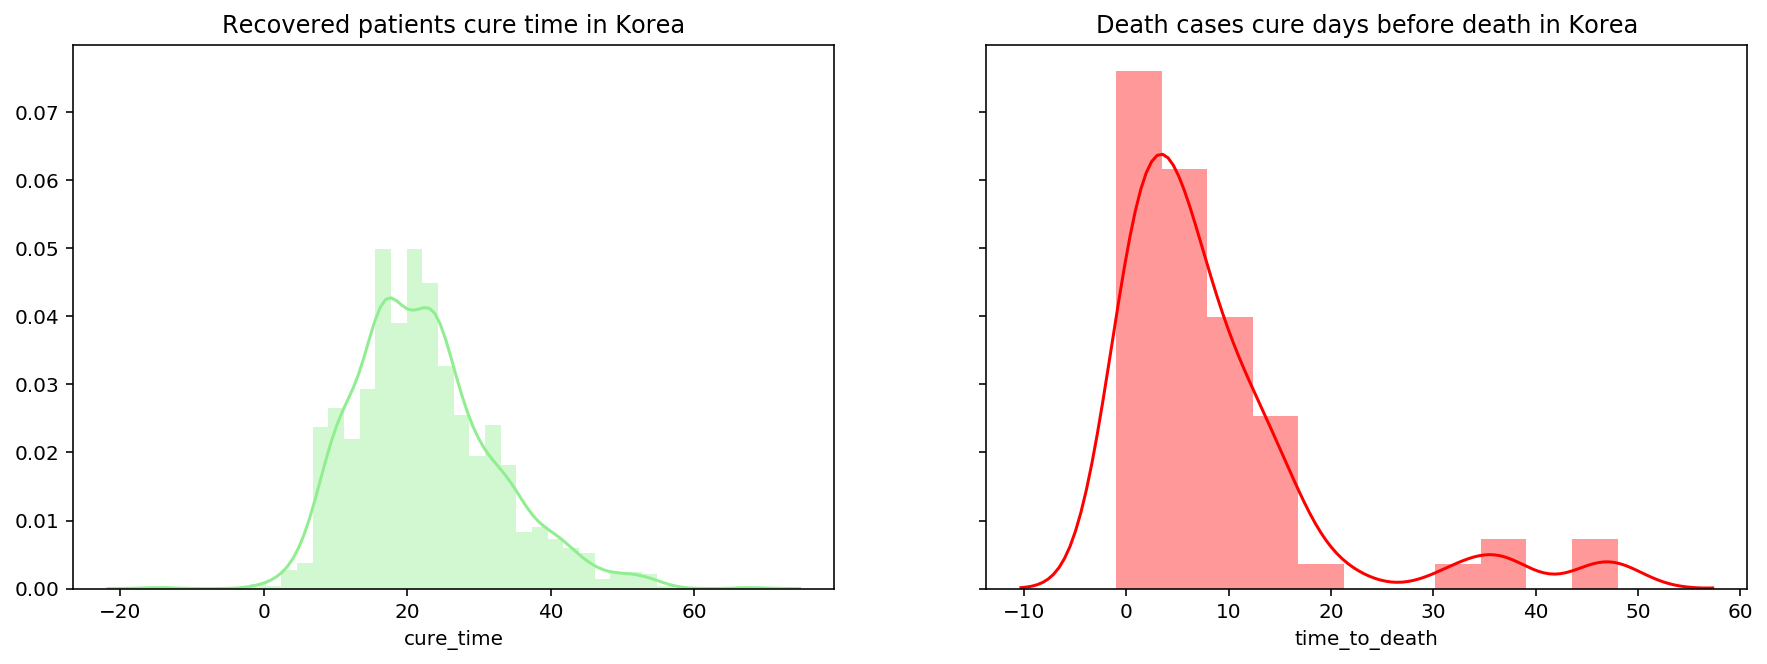

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15, 5))

sns.distplot(korea_recovered[korea_recovered['cure_time'].notnull()]['cure_time'],color=rec, ax=ax1).set_title('Recovered patients cure time in Korea')
sns.distplot(korea_deceased[korea_deceased['time_to_death'].notnull()]['time_to_death'],color=dth, ax=ax2).set_title('Death cases cure days before death in Korea')

fig.show()

It seems that in many cases cure is overdue and in critical cases patients deceased a few days after the cure started

## Typical symptoms

In [26]:
line['symptom'].value_counts().to_frame()[:10].style.background_gradient(cmap='Reds')

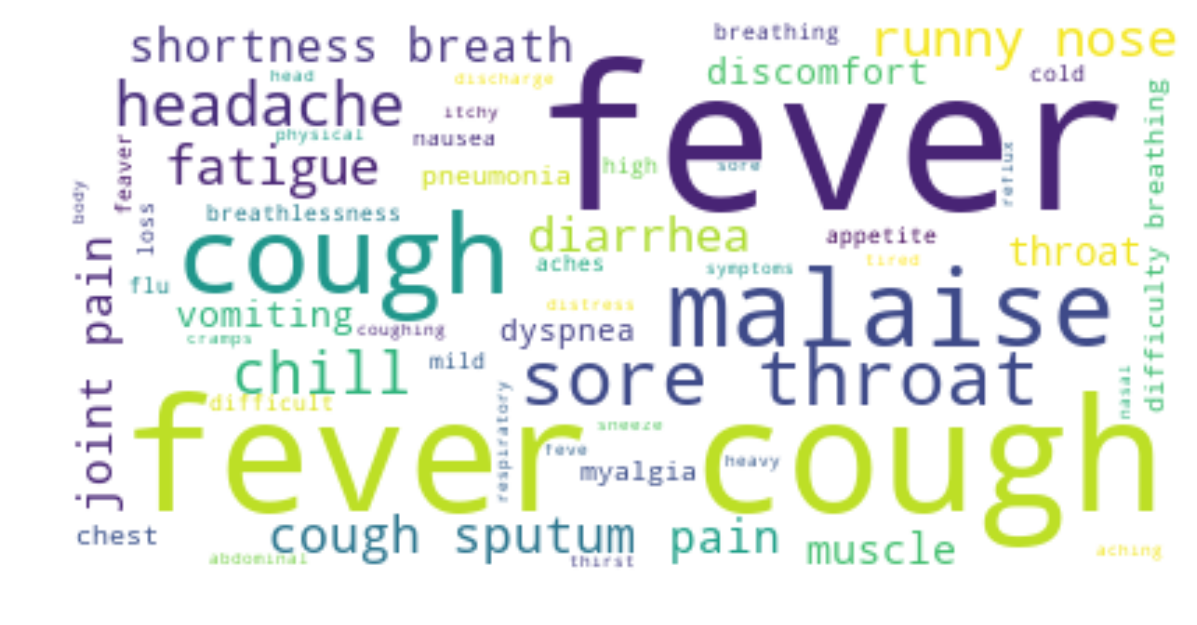

In [27]:
wordcloud = WordCloud(background_color="white").generate(' '.join(line[line['symptom'].notnull()]['symptom']))

# Display the generated image:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')

plt.axis("off")
plt.show()

Please keep in mind social distance rules, take care for your elder friends and relatives

*Stay safe, wash hands, keep calm, carry on, watch stats!*